In [1]:
# Our objective is to engineer better results in regards to marketing campaigns
# based on identified (trends) in campaign marketing data. Using targeted modeling
# techniques, we can identify which clients are most likely to contribute.
# Eventual Output: Marketing strategies to improve the success rates of marketing calls.

In [2]:
# machine_learning_project/
# │
# ├── data/             
# │   ├── marketing.csv       # Our marketing campaign data
# ├── src/                    
# │   ├── __init__.py         # Makes src a Python package
# │   ├── DataHandler.py      # Data loading and preprocessing
# │   ├── Model.py            # Model building and training
# │   ├── ModelInsights.py    # Relevant visualizations
# │
# └── main.py                 # Main script to run the project

In [ ]:
# Accuracy  Precision    Recall  F1 Score  Training Time   ROC AUC  \
# 0   0.90150   0.772205  0.599821  0.633795       5.614763  0.772186   
# 1   0.88600   0.684252  0.611421  0.634533     100.127706  0.673773   
# 2   0.84700   0.603758  0.603758  0.603758      61.829505  0.600929   
# 3   0.90175   0.781962  0.591845  0.624555   28535.285451       NaN   

#                  Model  
# 0  Logistic Regression  
# 1                  KNN  
# 2        Decision Tree  
# 3                  SVM  

In [ ]:
# # bank client data:
# 1 - age (numeric)
# 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
# 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
# 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
# 5 - default: has credit in default? (categorical: 'no','yes','unknown')
# 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
# 7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# # related with the last contact of the current campaign:
# 8 - contact: contact communication type (categorical: 'cellular','telephone')
# 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
# 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
# 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# # other attributes:
# 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
# 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
# 14 - previous: number of contacts performed before this campaign and for this client (numeric)
# 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# # social and economic context attributes
# 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
# 17 - cons.price.idx: consumer price index - monthly indicator (numeric)
# 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
# 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
# 20 - nr.employed: number of employees - quarterly indicator (numeric)

# Output variable (desired target):
# 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [3]:
# Will make classes for more modular and reusable code
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
class DataHandler:
    """
    Responsible for loading, preprocessing, and splitting data:
        filepath (str): The path to the dataset file
        columns_to_drop (list): Columns to be removed from the dataset
        target (str): The target variable for prediction
        dummy_variables (bool): Flag to decide if categorical variables should be converted to dummy/indicator variables
    """
    def __init__(self, filepath, drop_columns, target):
        # Initializes the DataHandler with file path, columns to drop, and target column
        self.filepath = filepath
        self.drop_columns = drop_columns
        self.target = target
        self.sampled_df = None
    def load_and_prepare(self):
        # Loads and preprocesses the dataset by dropping specified columns and encoding categorical variables if specified
        df = pd.read_csv(self.filepath, sep=';')
        # Dropping 'duration' column for leakage, and rows where it was 0 since those are automatic no's (bad data)
        df = df[df['duration'] != 0]
        df = df.drop(self.drop_columns, axis=1)
        df = pd.get_dummies(df, drop_first=True) # Encodes nominal -> binary
        if len(df)>20000:
            df = df.sample(n=20000, random_state=42) # Limits length of data for training time
        self.features = df.drop(self.target, axis=1)
        self.labels = df[self.target]
        # Returns the features and labels of the dataset
        return self.features, self.labels

    def split_data(self, test_size=0.2, random_state=42):
        # Splits the data into training and testing sets, scales
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.labels, test_size=test_size, random_state=random_state)
        scaler = StandardScaler()
        X_train_scaled =scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled, y_train, y_test

In [4]:
import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance

class Model:
    """
    Responsible for training and tuning machine learning models:
        model (estimator): The machine learning model to be trained and tuned
        tuning_params (dict): Hyperparameters for the model to tune
        use_random_search (bool): Flag to decide between using RandomizedSearchCV or GridSearchCV
    """
    def __init__(self, model, tuning_params, use_random_search=False):
        # Initializes Model obj with a specific machine learning model & tuning params
        self.model = model
        self.tuning_params = tuning_params # Dict with ranges for params
        self.use_random_search = use_random_search
        self.training_time = 0
        
    def fit_model(self, X_train, y_train):
        # Fits the model, selects best hyperparameters 
        start_time = time.time()  # Start timing
        if self.use_random_search:
            # Use RandomizedSearchCV for larger parameter spaces
            search = RandomizedSearchCV(self.model, self.tuning_params, scoring='recall',random_state=42,
                                       n_jobs=-1,n_iter=3,cv=3)
        else:
            # Use GridSearchCV for exhaustive search
            search = GridSearchCV(self.model, self.tuning_params, scoring='recall',cv=5)
        search.fit(X_train, y_train)
        self.model = search.best_estimator_
        self.training_time = time.time() - start_time  # Total training time
        print(f"Best Parameters: {search.best_params_}")
        # Return hypertuned model
        return self.model

    def evaluate(self, X_test, y_test):
        #Evaluates the trained model on the test set using various metrics
        predictions = self.model.predict(X_test)
        results = {
            "Accuracy": accuracy_score(y_test, predictions),
            "Precision": precision_score(y_test, predictions, average='macro', zero_division=0),
            "Recall": recall_score(y_test, predictions, average='macro', zero_division=0),
            "F1 Score": f1_score(y_test, predictions, average='macro'),
            "Training Time": self.training_time
        }
        if hasattr(self.model, "predict_proba"):  # Check if model supports probability estimates
            probabilities = self.model.predict_proba(X_test)[:, 1]
            results['ROC AUC'] = roc_auc_score(y_test, probabilities)
        #Returns dictionary containing accuracy, precision, recall, and F1 score
        return results

In [5]:
from sklearn.model_selection import learning_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, roc_curve, auc, precision_recall_curve)
class ModelInsights:
    """
    Creates visualizations from the data and model:
        model (estimator): The trained machine learning model
        X_train, y_train, X_test, y_test: Training and testing data
        feature_names (List[Str]): All our feature names for plotting
    """
    def __init__(self, model, X_train, y_train, X_test, y_test, feature_names):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.feature_names = feature_names
        self.model.fit(X_train, y_train)
        self.predictions = self.model.predict(X_test)
        if hasattr(self.model, "predict_proba"):  # Check if model supports probability estimates
            self.probas_ = self.model.predict_proba(X_test)
        
    def plot_confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.predictions)
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    def plot_roc_curve(self):
        fpr, tpr, thresholds = roc_curve(self.y_test, self.probas_[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    def plot_precision_recall_curve(self):
        precision, recall, thresholds = precision_recall_curve(self.y_test, self.probas_[:, 1])
        plt.figure()
        plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.show()

    def plot_feature_importance(self):
        try:
            importances = self.model.feature_importances_
            indices = np.argsort(importances)

            plt.figure(figsize=(10, 12))  # width, height
            plt.title('Feature Importances')
            plt.barh(range(len(indices)), importances[indices], color='b', align='center')
            plt.yticks(range(len(indices)), [self.feature_names[i] for i in indices])
            plt.xlabel('Relative Importance')
            plt.tight_layout()  # Fixes layout
            plt.show()
        except AttributeError:
            print("No feature_importances_ attribute for this model")

    def plot_learning_curve(self):
        train_sizes, train_scores, test_scores = learning_curve(self.model, self.X_train, self.y_train, 
                                                                cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        plt.figure()
        plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
        plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
        plt.xlabel('Training Sample Size')
        plt.ylabel('Score')
        plt.title('Learning Curve')
        plt.legend(loc="best")
        plt.show()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


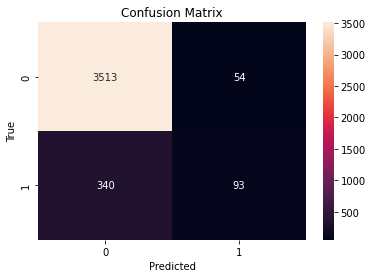

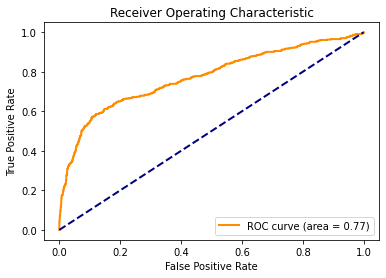

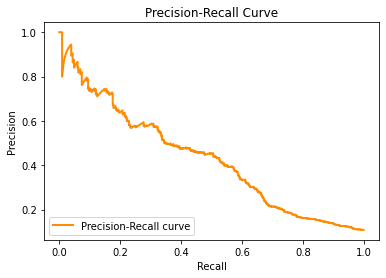

No feature_importances_ attribute for this model


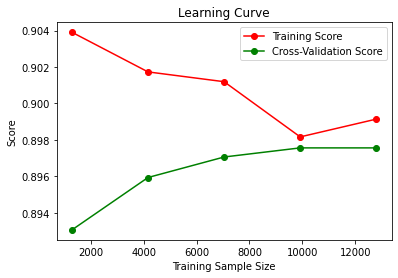

Best Parameters: {'n_neighbors': 3}


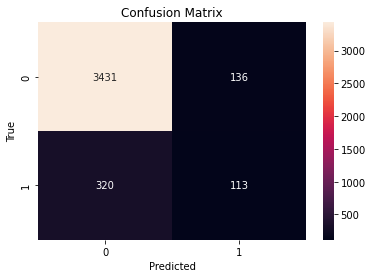

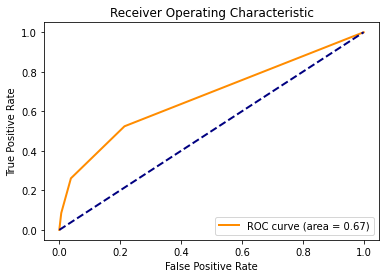

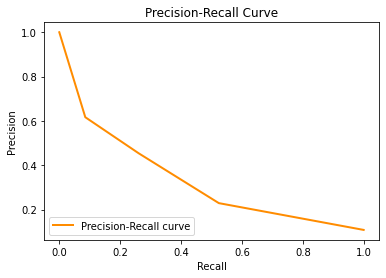

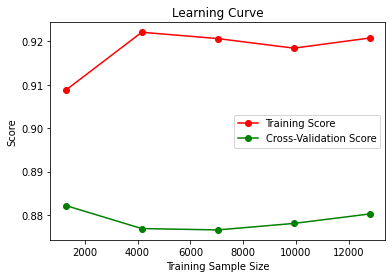

Best Parameters: {'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}


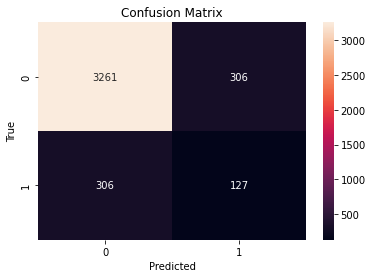

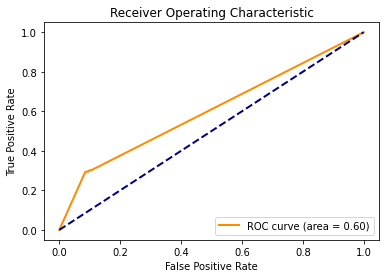

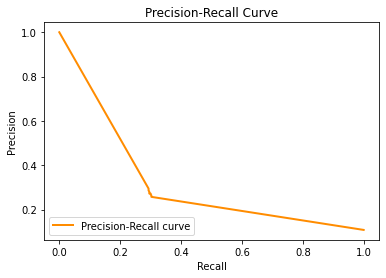

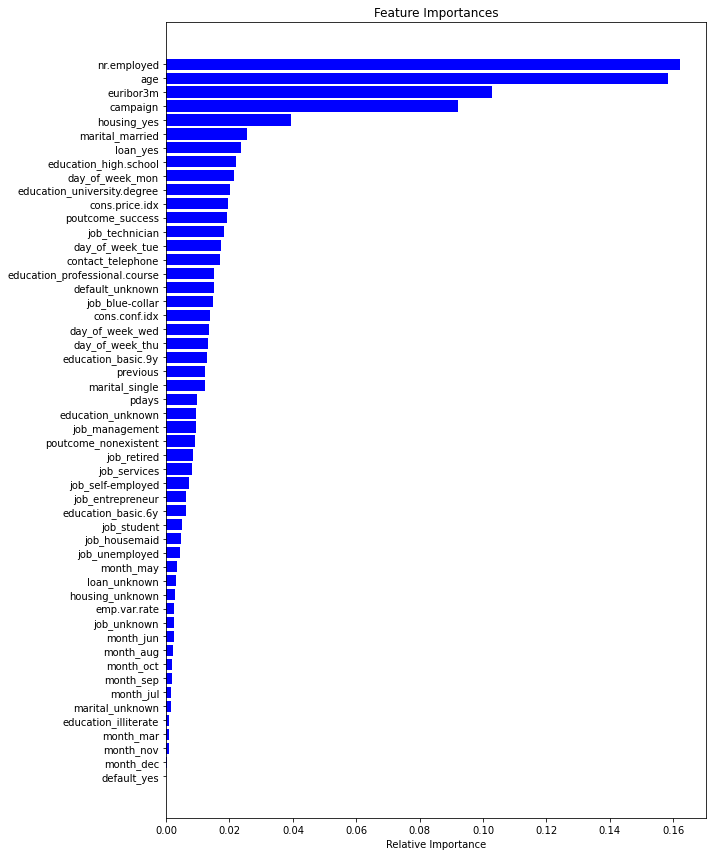

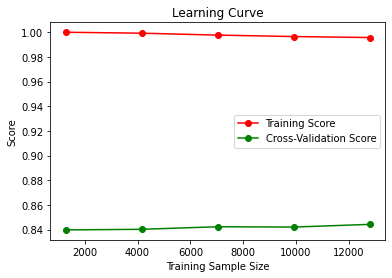

Best Parameters: {'kernel': 'rbf', 'C': 1}


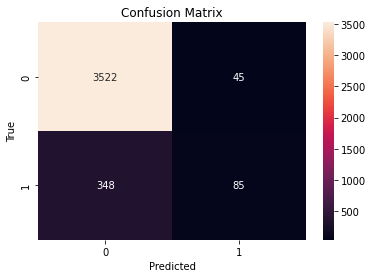

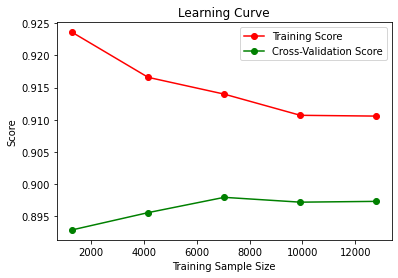

   Accuracy  Precision    Recall  F1 Score  Training Time   ROC AUC  \
0   0.90150   0.772205  0.599821  0.633795       5.614763  0.772186   
1   0.88600   0.684252  0.611421  0.634533     100.127706  0.673773   
2   0.84700   0.603758  0.603758  0.603758      61.829505  0.600929   
3   0.90175   0.781962  0.591845  0.624555   28535.285451       NaN   

                 Model  
0  Logistic Regression  
1                  KNN  
2        Decision Tree  
3                  SVM  


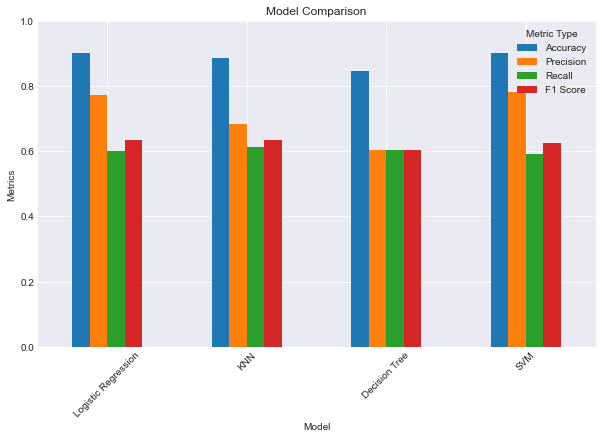

KeyError: 'Train Time'

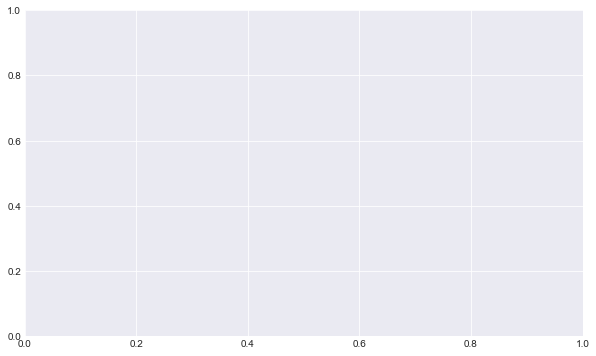

In [8]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearnex import patch_sklearn 

def plot_accuracy(results_df):
    # Setting the style
    plt.style.use('seaborn-darkgrid')
    # Plotting Train and Test Accuracy
    fig, ax = plt.subplots(figsize=(10, 6))
    results_df.plot(kind='bar', x='Model', y=['Accuracy', 'Precision', 'Recall', 'F1 Score'], ax=ax)
    ax.set_title('Model Comparison')
    ax.set_ylabel('Metrics')
    ax.set_xlabel('Model')
    ax.set_ylim([0, 1])  # Assuming accuracy is between 0 and 1
    plt.xticks(rotation=45)
    plt.legend(title='Metric Type')
    plt.show()
    
def plot_train_time(results_df):
    # Plotting Training Time
    fig, ax = plt.subplots(figsize=(10, 6))
    results_df.plot(kind='bar', x='Model', y='Training Time', color='teal', ax=ax)
    ax.set_title('Model Comparison - Training Time')
    ax.set_ylabel('Time (seconds)')
    ax.set_xlabel('Model')
    plt.xticks(rotation=45)
    plt.legend(['Training Time'])
    plt.show()
    
def main():
    patch_sklearn()
    # Define models and hyperparameter grids
    model_config = {
        'Logistic Regression': {
            'model': LogisticRegression(max_iter=1000),
            'params': {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear']},
            'use_random_search': False  # GridSearchCV is suitable for smaller parameter space
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {'n_neighbors': [3, 5, 7, 9]},
            'use_random_search': False  # Exhaustive search is manageable for KNN
        },
        'Decision Tree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'max_depth': [None, 10, 20, 30, 40, 50],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [1, 5, 10],
                'max_features': ['auto', 'sqrt', 'log2', None]
            },
            'use_random_search': False  
        },
        'SVM': {
            'model': SVC(random_state=42),
            'params': {'C': [1, 7], 'kernel': ['rbf', 'linear']},
            'use_random_search': True  # RandomizedSearchCV for larger parameter space efficiency
        }
    }
    
    # Prepare and split data using DataHandler Class
    data_handler = DataHandler('data/marketing.csv', ['duration'], 'y_yes')
    features, labels = data_handler.load_and_prepare()
    X_train, X_test, y_train, y_test = data_handler.split_data()
    feature_names = features.columns.tolist()
    
    # Train and evaluate models, compile results for comparison
    results = []
    important_features_dict = {}
    for name, config in model_config.items():
        trainer = Model(config['model'], config['params'], config['use_random_search'])
        trained_model = trainer.fit_model(X_train, y_train)
        metrics = trainer.evaluate(X_test, y_test)
        metrics['Model'] = name  # Adds model name to the dictionary
        results.append(metrics)
                       
        # Plots for the individual model
        insights = ModelInsights(trained_model, X_train, y_train, X_test, y_test, feature_names)
        insights.plot_confusion_matrix()
        if hasattr(trained_model, "predict_proba"):  # Check if model supports probability estimates
            insights.plot_roc_curve()
            insights.plot_precision_recall_curve()
        if hasattr(trained_model, 'feature_importances_') or hasattr(trained_model, 'coef_'):
            insights.plot_feature_importance()
        insights.plot_learning_curve()
    # Output results to review model performances
    results_df = pd.DataFrame(results)
    print(results_df)
    plot_accuracy(results_df)
    plot_train_time(results_df)
    
if __name__ == "__main__":
    main()